In [111]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd
import random
import matplotlib.lines as mlines
import beeswarm as bs
from scipy.special import erf
from mpl_toolkits.axes_grid.inset_locator import inset_axes


# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
mwc.set_plotting_style()

colors=sns.light_palette(color='#b73826', n_colors=8)
colors_alt=sns.color_palette('Blues')
sns.set_palette(colors)

colors_qual=sns.color_palette(
    ['#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b'])

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 20,
      'axes.facecolor': '#E3DCD0',
      'xtick.major' : 13,
      'xtick.labelsize': 'large',
      'ytick.labelsize': 13,
      'font.family': 'Arial',
      'grid.linestyle': ':',
      'grid.linewidth': 1.5,
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True,
      'legend.fontsize': 13}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)

In [112]:
# Import multipliers file as a dataframe

mults = pd.read_csv('../../data/models/multipliers_revised', index_col=0)

# Create lists of RBS and operator names
RBS_name = ['1147', '446', '1027', 'RBS1']
repressor_dict = dict(zip(RBS_name, [30, 62, 130, 610]))
operator_name = ['O1', 'O2']

# Make a dictionary for RBS, operator, and matrix files
matrix_dict = {}

for op in operator_name:
    inner_dict = {}
    for RBS in RBS_name:
        inner_dict[RBS] = np.loadtxt('../../data/models/%s%s_fixed_linear_all' % (op, RBS), skiprows=1)
    matrix_dict[op] = inner_dict
    
# Import list of mutant operators

mut_ops = pd.read_csv('../../notes/Onew_mutants_list.csv')

# Import measured binding energies

measured = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)

# Make dictionary of mutant operators and measured binding energies
energies_list = []
low_list = []
high_list = []
mut_list = []
seq_list = []
for name in mut_ops.ID:
    for op in measured.operator:
        if name.lstrip('mut') in op:
            energies_list.append(measured.energy_kBT[measured.operator==op].values[0])
            low_list.append(measured.energy_kBT_low[measured.operator==op].values[0])
            high_list.append(measured.energy_kBT_high[measured.operator==op].values[0])
            mut_list.append('O1new' + name.lstrip('mut'))
            seq_list.append(mut_ops.seq[mut_ops.ID==name].values[0])
            
# Make new dataframe storing these values
df = pd.DataFrame({'ID' : mut_list, 'sequence' : seq_list,\
                   'measured_energy' : energies_list, 'low_bound' : low_list, 'high_bound' : high_list})

In [113]:
# Import predictions

preds = pd.read_csv('../../notes/binding_energy_predictions.csv', index_col=0)

In [114]:
# Add predictions to dataframe

O1_preds = preds.sort_values(by='mutant')['energy_prediction']\
           [(preds.matrix_operator=='O1') & (preds.matrix_repressor==130)].values
O2_preds = preds.sort_values(by='mutant')['energy_prediction']\
           [(preds.matrix_operator=='O2') & (preds.matrix_repressor==610)].values

df['O1'] = O1_preds
df['O2'] = O2_preds

In [115]:
# Melt the data frame to make it tidy.
df = pd.melt(df, id_vars=['ID', 'measured_energy', 'low_bound', 'high_bound', 'sequence'], value_vars=['O1', 'O2'], \
            var_name='prediction_matrix', value_name='energy_prediction')

# Write function to count number of differences between mutant and reference sequence
def num_diff(seq1, seq2):
    diffs = [1 for i in range(len(seq1)) if seq1[i]!=seq2[i]]
    return sum(diffs)
        
wt_dict = {'O1': 'AATTGTGAGCGGATAACAATT', 'O2' : 'AAATGTGAGCGAGTAACAACC'}

# Add a column keeping track of number of bp mutated relative to reference sequence

num_mut = []
for i in range(len(df)):
    num_mut.append(num_diff(wt_dict[df.iloc[i]['prediction_matrix']], df.iloc[i]['sequence']))
df['num_mutations'] = num_mut

# Add a column measuring the difference in magnitude between measured energy and energy prediction.
diffs = []
for i in range(len(df)):
    diffs.append(abs(df.iloc[i]['measured_energy'] - df.iloc[i]['energy_prediction']))
df['error'] = diffs

df.head()

,ID,measured_energy,low_bound,high_bound,sequence,prediction_matrix,energy_prediction,num_mutations,error
0,O1new005,-12.242242,-12.340340,-12.165165,AATTGTGAGCGGAGAACAATT,O1,-12.636853,1,0.394611
1,O1new007,-15.297297,-15.458458,-15.178178,AATTGTGAGCGCATAACAATT,O1,-15.708823,1,0.411526
2,O1new008,-14.988989,-15.108108,-14.890891,AATTGTGAGCGGATCACAATT,O1,-15.215924,1,0.226935
3,O1new009,-12.501502,-12.627628,-12.396396,AATTGTGAGCGGAAAACAATT,O1,-12.911755,1,0.410253
4,O1new010,-11.296296,-11.408408,-11.205205,AATTGCGAGCGGATAACAATT,O1,-12.137593,1,0.841296


In [116]:
# Input function for calculating titration curves

def R_titration(energy, R):
    return(1/(1 + 2 * R/4.6E6 * np.exp(-energy)))

In [117]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '2016' + '*' + '*csv') + glob.glob(datadir + '2017' + '*' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
data = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]

data.head()

Number of independent data-sets: 30


,date,username,operator,binding_energy,rbs,repressors,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160916,sbarnes,O1new007,-14.67,RBS1L,870,3070.224132,82.289468,0.005156
3,20160916,sbarnes,O1new007,-14.67,RBS1,610,3070.191407,82.256743,0.005154
4,20160916,sbarnes,O1new007,-14.67,RBS1027,130,3052.491546,64.556881,0.004045
5,20160916,sbarnes,O1new007,-14.67,RBS446,62,3112.649762,124.715098,0.007814
6,20160916,sbarnes,O1new007,-14.67,RBS1147,30,3203.353581,215.418917,0.013497


In [118]:
# Replace values reading "01new..." with "O1new..."
replace_dict = {}
for val in data.operator.unique():
    if val.startswith('01new'):
        replace_dict[val] = 'O1new' + val[-3:]
for key, val in replace_dict.items():
    data.replace(key, val, inplace=True)

In [119]:
# Replace incorrect binding energies with correct binding energies
energies = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)
for op in data.operator.unique():
    if op in energies.operator.unique():
        data.replace(data.binding_energy[data.operator==op].unique(),\
                   energies.energy_kBT[energies.operator==op].unique(), inplace=True)
data.head()

,date,username,operator,binding_energy,rbs,repressors,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160916,sbarnes,O1new007,-15.297297,RBS1L,870,3070.224132,82.289468,0.005156
3,20160916,sbarnes,O1new007,-15.297297,RBS1,610,3070.191407,82.256743,0.005154
4,20160916,sbarnes,O1new007,-15.297297,RBS1027,130,3052.491546,64.556881,0.004045
5,20160916,sbarnes,O1new007,-15.297297,RBS446,62,3112.649762,124.715098,0.007814
6,20160916,sbarnes,O1new007,-15.297297,RBS1147,30,3203.353581,215.418917,0.013497


In [120]:
fc_logs = np.log10(data.fold_change_A.values)
data['fold_change_log'] = fc_logs


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


In [121]:
# Remove fold change outliers
data = data[data['fold_change_A'] < 1.1]

# Calculate log of each fold change value
fc_logs = np.log10(data.fold_change_A.values)
data['fold_change_log'] = fc_logs

# Extract the mean fold-change values for each operator-RBS pair.
mean_fc = data.groupby(('operator', 'repressors', 'binding_energy'))['fold_change_A'].mean()
mean_fc = mean_fc.reset_index()

log_mean = data.groupby(('operator', 'repressors', 'binding_energy'))['fold_change_log'].mean()
log_mean = log_mean.reset_index()

log_std = data.groupby(('operator', 'repressors', 'binding_energy'))['fold_change_log'].std()
log_std = log_std.reset_index()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


In [122]:
# Establish bounds for error bars
mean_fc['error_up'] = 10**(log_mean.fold_change_log + log_std.fold_change_log)
mean_fc['error_down'] = 10**(log_mean.fold_change_log - log_std.fold_change_log)

In [123]:
df.head()

,ID,measured_energy,low_bound,high_bound,sequence,prediction_matrix,energy_prediction,num_mutations,error
0,O1new005,-12.242242,-12.340340,-12.165165,AATTGTGAGCGGAGAACAATT,O1,-12.636853,1,0.394611
1,O1new007,-15.297297,-15.458458,-15.178178,AATTGTGAGCGCATAACAATT,O1,-15.708823,1,0.411526
2,O1new008,-14.988989,-15.108108,-14.890891,AATTGTGAGCGGATCACAATT,O1,-15.215924,1,0.226935
3,O1new009,-12.501502,-12.627628,-12.396396,AATTGTGAGCGGAAAACAATT,O1,-12.911755,1,0.410253
4,O1new010,-11.296296,-11.408408,-11.205205,AATTGCGAGCGGATAACAATT,O1,-12.137593,1,0.841296


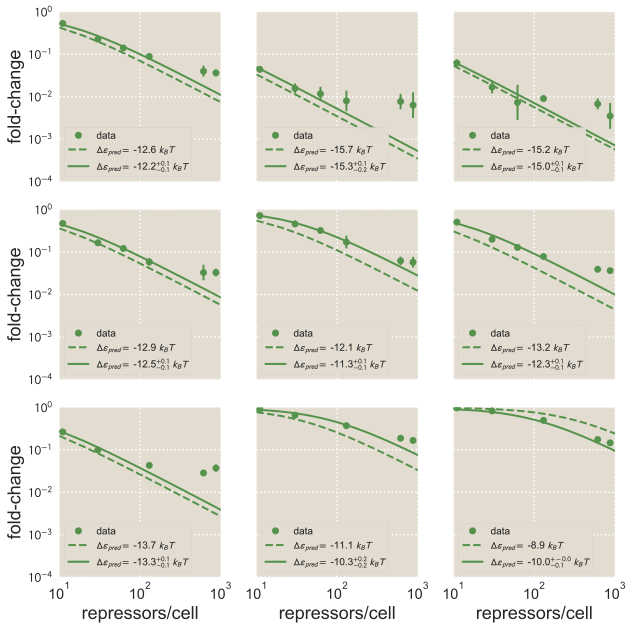

In [124]:
# 1 bp mutants 

fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(9, 9))
mut_list = list(df.ID[0:9].values) 
mut_1 = ['O1new' + m[-3:] for m in mut_list]
outlier_list = ['O1new012', 'O1new013', 'O1new014']
rep_x = np.linspace(10, 1000, 100)
color=colors_qual[0]

axes = ax.ravel()

for i, mut in enumerate(mut_1):
    energy_meas = df.measured_energy[(df.ID==mut_list[i]) & (df.prediction_matrix=='O1')].values[0]
    energy_pred = df.energy_prediction[(df.ID==mut_list[i]) & (df.prediction_matrix=='O1')].values[0]
    error_up = df.high_bound[df.ID==mut].unique() - energy_meas
    error_down = energy_meas - df.low_bound[df.ID==mut].unique()
    
    # Plot theory curve
    axes[i].plot(rep_x, np.log10(R_titration(energy_meas, rep_x)), color=color)
    axes[i].plot(rep_x, np.log10(R_titration(energy_pred, rep_x)), ls='--', color=color)
    
    # Plot data points
    if mut in outlier_list:
        axes[i].errorbar(log_mean.repressors[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     log_mean.fold_change_log[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     yerr=log_std.fold_change_log[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     ls='', marker='o', zorder=9, color=color)
    else:
        axes[i].errorbar(log_mean.repressors[(log_mean.operator==mut)],\
                     log_mean.fold_change_log[log_mean.operator==mut],\
                     yerr=log_std.fold_change_log[log_mean.operator==mut], ls='', marker='o',\
                     zorder=9, 
                     color=color)

    
    axes[i].set_xscale('log')
    axes[i].set_xlim(10, 1000)
    axes[i].set_ylim(-4, 0)
    axes[i].set_yticks([-4, -3, -2, -1, 0])
    axes[i].set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    
    # Add legend
    ims = []
    ims.append(mlines.Line2D([], [], marker='o',label='data', linestyle='None', color=color))
    ims.append(mlines.Line2D([], [], label=(r'$\Delta \varepsilon_{pred} =$ %0.1f $k_BT$' % energy_pred),\
                             linestyle='--', color=color))
    ims.append(mlines.Line2D([], [], label=(r'$\Delta \varepsilon_{pred} =$ %0.1f$^{+%0.1f}_{-%0.1f}\ k_BT$'\
                                            % (energy_meas, error_up, error_down)),\
                             linestyle='-', color=color))
    axes[i].add_artist(axes[i].legend(handles=ims, loc='lower left', fontsize=10))

for j in [0, 3, 6]:
    axes[j].set_ylabel('fold-change') 
for k in [6, 7, 8]:
    axes[k].set_xlabel('repressors/cell')
 
plt.tight_layout()
plt.savefig('all_1bp.pdf', bbox_inches='tight')

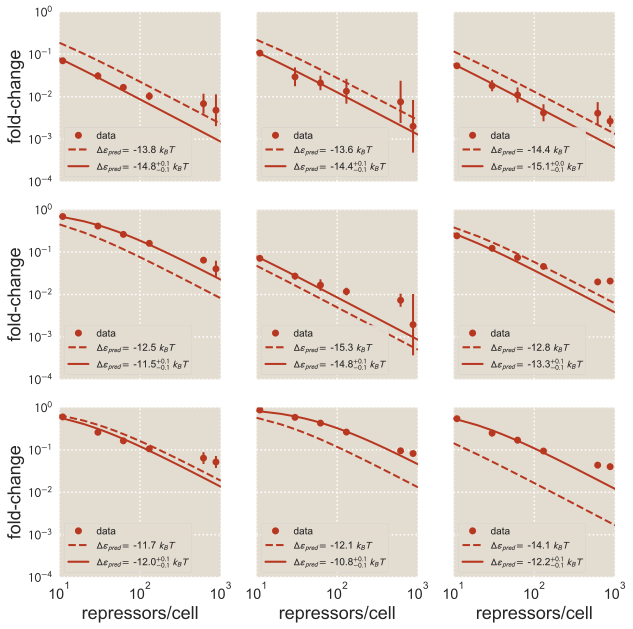

In [125]:
# 2 bp mutants 

fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(9, 9))
mut_list = list(df.ID[9:18].values) 
mut_1 = ['O1new' + m[-3:] for m in mut_list]
outlier_list = ['O1new012', 'O1new013', 'O1new014']
rep_x = np.linspace(10, 1000, 100)
color=colors_qual[1]

axes = ax.ravel()

for i, mut in enumerate(mut_1):
    energy_meas = df.measured_energy[(df.ID==mut_list[i]) & (df.prediction_matrix=='O1')].values[0]
    energy_pred = df.energy_prediction[(df.ID==mut_list[i]) & (df.prediction_matrix=='O1')].values[0]
    error_up = df.high_bound[df.ID==mut].unique() - energy_meas
    error_down = energy_meas - df.low_bound[df.ID==mut].unique()
    
    # Plot theory curve
    axes[i].plot(rep_x, np.log10(R_titration(energy_meas, rep_x)), color=color)
    axes[i].plot(rep_x, np.log10(R_titration(energy_pred, rep_x)), ls='--', color=color)
    
    # Plot data points
    if mut in outlier_list:
        axes[i].errorbar(log_mean.repressors[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     log_mean.fold_change_log[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     yerr=log_std.fold_change_log[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     ls='', marker='o', zorder=9, color=color)
    else:
        axes[i].errorbar(log_mean.repressors[(log_mean.operator==mut)],\
                     log_mean.fold_change_log[log_mean.operator==mut],\
                     yerr=log_std.fold_change_log[log_mean.operator==mut], ls='', marker='o',\
                     zorder=9, color=color)

    
    axes[i].set_xscale('log')
    axes[i].set_xlim(10, 1000)
    axes[i].set_ylim(-4, 0)
    axes[i].set_yticks([-4, -3, -2, -1, 0])
    axes[i].set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    
    # Add legend
    ims = []
    ims.append(mlines.Line2D([], [], marker='o',label='data', linestyle='None', color=color))
    ims.append(mlines.Line2D([], [], label=(r'$\Delta \varepsilon_{pred} =$ %0.1f $k_BT$' % energy_pred),\
                             linestyle='--', color=color))
    ims.append(mlines.Line2D([], [], label=(r'$\Delta \varepsilon_{pred} =$ %0.1f$^{+%0.1f}_{-%0.1f}\ k_BT$'\
                                            % (energy_meas, error_up, error_down)),\
                             linestyle='-', color=color))
    axes[i].add_artist(axes[i].legend(handles=ims, loc='lower left', fontsize=10))

for j in [0, 3, 6]:
    axes[j].set_ylabel('fold-change') 
for k in [6, 7, 8]:
    axes[k].set_xlabel('repressors/cell')
 
plt.tight_layout()
plt.savefig('all_2bp.pdf', bbox_inches='tight')

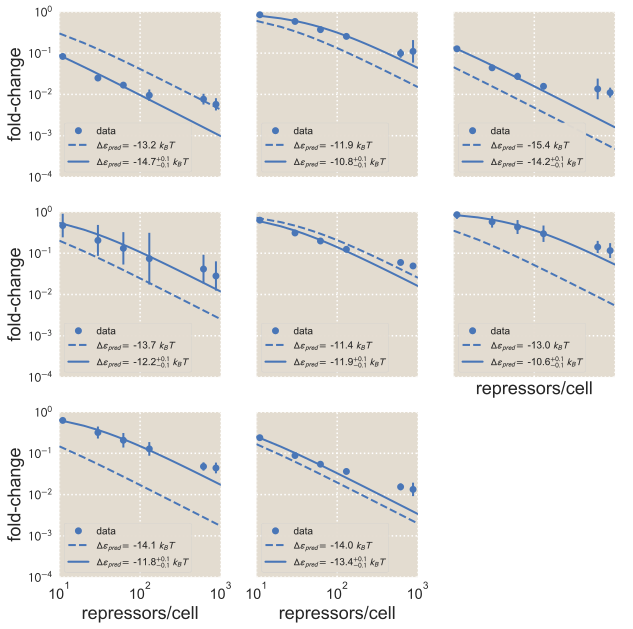

In [126]:
# 1 bp mutants 

fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(9, 9))
mut_list = list(df.ID[19:27].values) 
mut_1 = ['O1new' + m[-3:] for m in mut_list]
outlier_list = ['O1new012', 'O1new013', 'O1new014']
rep_x = np.linspace(10, 1000, 100)
color=colors_qual[2]

axes = ax.ravel()

for i, mut in enumerate(mut_1):
    energy_meas = df.measured_energy[(df.ID==mut_list[i]) & (df.prediction_matrix=='O1')].values[0]
    energy_pred = df.energy_prediction[(df.ID==mut_list[i]) & (df.prediction_matrix=='O1')].values[0]
    
    # Plot theory curve
    axes[i].plot(rep_x, np.log10(R_titration(energy_meas, rep_x)), color=color)
    axes[i].plot(rep_x, np.log10(R_titration(energy_pred, rep_x)), ls='--', color=color)
    
    # Plot data points
    if mut in outlier_list:
        axes[i].errorbar(log_mean.repressors[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     log_mean.fold_change_log[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     yerr=log_std.fold_change_log[(log_mean.operator==mut) & (log_mean.repressors!=62)],\
                     ls='', marker='o', zorder=9, color=color)
    else:
        axes[i].errorbar(log_mean.repressors[(log_mean.operator==mut)],\
                     log_mean.fold_change_log[log_mean.operator==mut],\
                     yerr=log_std.fold_change_log[log_mean.operator==mut], ls='', marker='o',\
                     zorder=9, color=color)

    
    axes[i].set_xscale('log')
    axes[i].set_xlim(10, 1000)
    axes[i].set_ylim(-4, 0)
    axes[i].set_yticks([-4, -3, -2, -1, 0])
    axes[i].set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    
    # Add legend
    ims = []
    ims.append(mlines.Line2D([], [], marker='o',label='data', linestyle='None', color=color))
    ims.append(mlines.Line2D([], [], label=(r'$\Delta \varepsilon_{pred} =$ %0.1f $k_BT$' % energy_pred),\
                             linestyle='--', color=color))
    ims.append(mlines.Line2D([], [], label=(r'$\Delta \varepsilon_{pred} =$ %0.1f$^{+%0.1f}_{-%0.1f}\ k_BT$'\
                                            % (energy_meas, error_up, error_down)),\
                             linestyle='-', color=color))
    axes[i].add_artist(axes[i].legend(handles=ims, loc='lower left', fontsize=10))


# Turn off unneeded axes
axes[8].axis('off')
    
for j in [0, 3, 6]:
    axes[j].set_ylabel('fold-change') 
for k in [5, 6, 7]:
    axes[k].set_xlabel('repressors/cell')
 
plt.tight_layout()
plt.savefig('all_3bp.pdf', bbox_inches='tight')